In [7]:
import numpy as np
import random
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import dates
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from lmfit import Minimizer,minimize, Parameters, Parameter, report_fit
from statsmodels.tsa.arima_model import ARIMA

# step 0: data importation #

In [8]:
csv_url="https://raw.githubusercontent.com/ADelau/proj0016-epidemic-data/main/data.csv"
data = pd.read_csv(csv_url)

In [10]:
data.tail(20)

Day  num_positive  num_tested  num_hospitalised  \
51   52           542         676               204   
52   53           575         714               225   
53   54           596         744               231   
54   55           591         745               254   
55   56           710         871               262   
56   57           733         919               265   
57   58           827        1019               282   
58   59           870        1106               298   
59   60           959        1172               317   
60   61           991        1213               333   
61   62          1077        1346               364   
62   63          1210        1492               404   
63   64          1279        1570               439   
64   65          1303        1628               485   
65   66          1473        1802               518   
66   67          1550        1942               555   
67   68          1699        2131               608   
68   69          1799        2249               671   
69   70          1884        2372               738   
70   71          2035        2539               774   

    num_cumulative_hospitalizations  num_critical  num_fatalities  
51                              372            18              15  
52                              407            20              15  
53                              435            22              15  
54                              476            19              16  
55                              509            23              17  
56                              541            30              18  
57                              588            33              20  
58                              639            40              20  
59                              689            45              20  
60                              740            44              22  
61                              799            43              24  
62                              880            45              25  
63                              949            45              30  
64                             1028            45              34  
65                             1106            46              37  
66                             1197            55              38  
67                             1297            57              39  
68                             1412            62              41  
69                             1539            67              41  
70                             1654            76              43

# step 1: setting up the model #

## step 1.1: writing the ode system ##

In [4]:
# z is an array with compartiments
# t 
#params
def ode_model(z,t,params):
    N=sum(z)
    S,I,R = z
    beta_SI = params['beta_SI'].value
    gamma_IR = params['gamma_IR'].value
        
    #beta = beta_i*(1.1-tau*t) beta peut être une variable du temps
    dSdt = -beta_SI*(S*I)/(N)
    dIdt = +beta_SI*(S*I)/(N) - gamma_IR*I
    dRdt= +gamma_IR*I
    
    return [dSdt, dIdt, dRdt]

## step 1.2: writing the parameters, initial values and guesses ##


In [5]:
# the lmfit module uises an orderd dict structure
# to store the parameters to be optimized
# https://lmfit.github.io/lmfit-py/parameters.html

params = Parameters()
params.add('beta_SI', value=0.15, min=0.1, max=10)
params.add('gamma_IR', value= 0.05, min=0.1, max=10)

params.add('I0',value=15,min=1,max=500)

params.add('OBS_Tr_SI_to_nbTest',value=0.25,min=0.05,max=1)
params.add('OBS_nbTest_to_nbpos',value=0.75,min=0.5,max=0.9)





In [6]:
params

Parameters([('beta_SI', <Parameter 'beta_SI', value=0.15, bounds=[0.1:10]>),
            ('gamma_IR', <Parameter 'gamma_IR', value=0.1, bounds=[0.1:10]>),
            ('I0', <Parameter 'I0', value=15, bounds=[1:500]>),
            ('OBS_Tr_SI_to_nbTest',
             <Parameter 'OBS_Tr_SI_to_nbTest', value=0.25, bounds=[0.05:1]>),
            ('OBS_nbTest_to_nbpos',
             <Parameter 'OBS_nbTest_to_nbpos', value=0.75, bounds=[0.5:0.9]>)])

## step 1.3 writing the solver ##

In [66]:
#this function solves the ode
#input: function deriv, initial compartiments y0, t, and N,ps as arguments??
#output: the ode solution
def odesol(y,t,ps):
    
    ts = np.linspace(0, t, t+1)
    result = odeint(ode_model, y, ts, args=(ps,))
    
    return result


def ode_solver(tspan, initial_conditions, params):
    #parvals = params.valuesdict()
        
    
    beta, gamma = params['beta_SI'].value, params['gamma_IR'].value
    
    
    res = odeint(ode_model, initial_conditions, tspan, args=(params,))
    return res

In [67]:
ts = np.linspace(0, 70,2)
ts

array([ 0., 70.])

In [68]:
test=ode_solver(ts, [1e6-50,50,0], params)
test

array([[9.99950000e+05, 5.00000000e+01, 0.00000000e+00],
       [9.95175171e+05, 1.63382576e+03, 3.19100320e+03]])

In [69]:
# this function generate the observation dataframe
def create_obsdf(model,ps,data):
    
    result=pd.DataFrame(columns=data.columns)
    result['Day']=data['Day']
    nb_trans_SI=ps['beta_SI']*(model['S']*(model['I']))/(model['S']+model['I']+model['R'])
    

    result['num_tested']=ps['OBS_Tr_SI_to_nbTest'].value*nb_trans_SI
    
    #result['num_hospitalised']=model['H']
    #result['num_cumulative_hospitalizations']=result['num_hospitalised'].diff().fillna(0).cumsum()
    #result['num_critical']=model['ICU']
    #result['num_fatalities']=model['D']
    return result
    

#test['num_tested']=params['OBS_Tr_EI_to_nbTest'].value*

# step 2: fitting the model #

## step 2.1: write objective function ##

In [70]:
#NOT USED, SEE RESIDUAL2
#this function compute residuals,
#ie objective function to be minimized in the optimization function
def residual(ps, ts, data, N):
    
    
    I0 = ps['I0'].value
    S0=N-I0
    R0=0

    
    y0 = S0,I0,R0
    
    model = pd.DataFrame(odesol(y0,ts,N,ps), columns=['S','I','R'])
    obs_df=create_obsdf(model,ps,data)
    component1=(obs_df['num_tested']-data['num_tested']).ravel()
    
    # penalty function to think more about !!!
    print(ps)
    return component1

In [74]:
#residual function from lmfit website
#ts is the x
def error(params, data):
    # unpack parameters: extract .value attribute for each parameter
    parvals = params.valuesdict()
    beta=parvals['beta_SI']
    gamma=parvals['gamma_IR']
    I0=parvals['I0']
    OBS_Tr_SI_to_nbTest=parvals['OBS_Tr_SI_to_nbTest']
    OBS_nbTest_to_nbpos=parvals['OBS_nbTest_to_nbpos']
    
    # useful scalars, arrays
    
    nb_days=data.shape[0]
    array_data=data['num_tested'].to_numpy()
    ## A CORRIGER !ode_solver(t, initial_conditions, params):
    array_model=odesol(np.array([1e6-I0,I0,0]),nb_days,params)
    
    #array initialisation
    
    ratio_model=np.empty(array_data.shape[0]-1)
    ratio_data=np.empty(array_data.shape[0]-1)
    

    for i in range(ratio_model.shape[0]-1):
        if array_data[i] == 0: # handle divide by zero
            ratio_data[i]=(array_data[i+1]-array_data[i])/(array_data[i+1]/2)
        else:
            ratio_data[i]=(array_data[i+1]-array_data[i])/array_data[i]
        ratio_model[i]=(array_model[i+1][1]-array_model[i][1])/array_model[i][1]
    
    return ratio_model-ratio_data

In [75]:
def find_timespane(data):
    return np.linspace(0,data.shape[0]-1,data.shape[0])
def find_timespane2(data):
    return np.array(data.index.tolist())

In [76]:
error_array=error(params,data)

In [77]:
error_array

array([-1.94873145e+00, -4.48731822e-01, -2.82065548e-01,  3.01267374e-01,
        2.17933607e-01,  1.51266484e-01, -1.39317844e+00,  5.81095575e-03,
        1.38221494e-01, -7.10640346e-01,  1.59371939e-01,  5.12632156e-02,
       -1.00252582e-01, -1.32948637e-01, -1.26516603e-01,  1.45600048e-01,
       -1.36240364e-01, -3.64604946e-02, -7.77743274e-02,  1.94114156e-01,
       -1.15410618e-01,  1.36969320e-01, -2.14371030e-01,  1.74709640e-01,
       -2.58607483e-01,  8.23968068e-03,  7.18676885e-02,  4.07214475e-02,
       -7.37536750e-02, -1.70977409e-01, -1.78707982e-03,  1.95126444e-01,
       -3.68928272e-01,  1.45912505e-01,  3.16281645e-02, -1.98766033e-01,
        3.58472075e-02, -1.91194675e-01,  7.15523997e-02,  2.63284396e-02,
       -1.06672651e-01, -1.30598851e-01,  1.51808153e-01, -1.88918185e-01,
       -2.04078419e-02, -7.73364393e-04, -9.46790536e-02,  7.17334642e-02,
       -1.10229898e-01, -8.37521342e-03, -1.00431141e-01, -5.03029554e-03,
        9.16114787e-03,  

## step 2.2: write optimization command ##

In [88]:
result = minimize(error, params, args=(data,), method ='leastsq')

In [89]:
result

In [92]:
I0 = result.params['I0'].value

y0 = 1e6-I0,I0,0

model = pd.DataFrame(odesol(y0,70,result.params), columns=['S','I','R'])
obs_df=create_obsdf(model,result.params,data)
obs_df

Day num_positive  num_tested num_hospitalised  \
0     1          NaN    0.562492              NaN   
1     2          NaN    0.591328              NaN   
2     3          NaN    0.621643              NaN   
3     4          NaN    0.653512              NaN   
4     5          NaN    0.687014              NaN   
..  ...          ...         ...              ...   
66   67          NaN   15.183705              NaN   
67   68          NaN   15.958278              NaN   
68   69          NaN   16.772151              NaN   
69   70          NaN   17.627295              NaN   
70   71          NaN   18.525778              NaN   

   num_cumulative_hospitalizations num_critical num_fatalities  
0                              NaN          NaN            NaN  
1                              NaN          NaN            NaN  
2                              NaN          NaN            NaN  
3                              NaN          NaN            NaN  
4                              NaN          NaN            NaN  
..                             ...          ...            ...  
66                             NaN          NaN            NaN  
67                             NaN          NaN            NaN  
68                             NaN          NaN            NaN  
69                             NaN          NaN            NaN  
70                             NaN          NaN            NaN  

[71 rows x 7 columns]

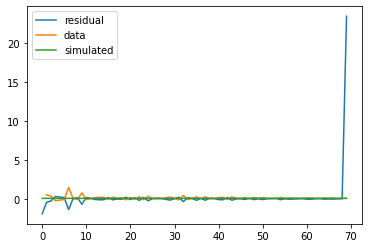

In [94]:
plt.plot(result.residual,label='residual')

plt.plot((data['num_tested'].values[1:] - data['num_tested'].values[:-1])/data['num_tested'].values[:-1],label='data')

plt.plot((obs_df['num_tested'].values[1:] - obs_df['num_tested'].values[:-1])/obs_df['num_tested'].values[:-1],label='simulated')


plt.legend()

In [20]:
tspan=find_timespane(data)

mini = Minimizer(error, params, args=(initial_condition, tspan, data), method ='leastsq')
result = mini.minimize()
#result

NameError: name 'initial_condition' is not defined